In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize
import sunpy.map
import glob
from astropy import units as u
import sunpy.sun.constants

from data_process.aia_part.get_aia_simu import get_aia_simu
from data_process.aia_part.get_aia_simu_5 import get_aia_simu_5
from data_process.error_function import error_function
from data_process.error_function_5 import error_function_5

In [2]:
eve_frame=pd.read_csv('data_process/eve_part/data/daily_date.csv')

date=[]
for i in eve_frame['date']:
    date.append(datetime.datetime.strptime(i, '%Y-%m-%d'))
    
eve_frame['date']=date
eve_frame=eve_frame.set_index('date')

# EVE

IDL 下载的EVE数据目前还缺了几天

使用2011-02-03 ~2011-03-03 25天的 EVE 数据作为"标准"

In [4]:
frame=pd.read_csv('data_process/eve_part/data/daily_date.csv')

date=[]
for i in frame['date']:
    date.append(datetime.datetime.strptime(i, '%Y-%m-%d'))
    
frame['date']=date
frame=frame.set_index('date')
frame.head()

daily_mean  daily_stddev
date                                
2011-01-11   30.374087      0.000191
2011-01-12   30.374090      0.000170
2011-01-13   30.374055      0.000182
2011-01-14   30.374055      0.000181
2011-01-15   30.374071      0.000179

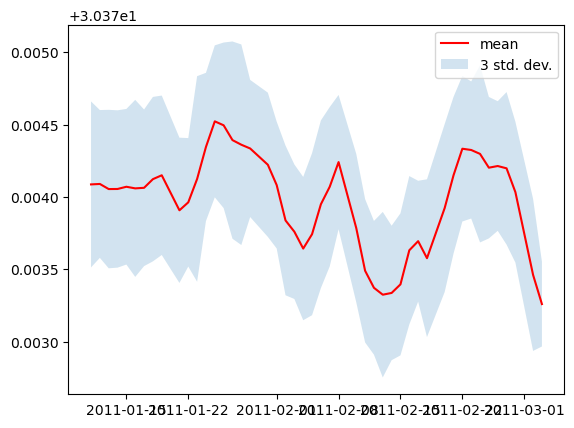

In [6]:
fig,ax=plt.subplots()
ax.plot(frame.index,frame['daily_mean'],'r-',label='mean')

ax.fill_between(frame.index,
                frame['daily_mean']-3*frame['daily_stddev'],
                frame['daily_mean']+3*frame['daily_stddev'],
               alpha=0.2,
               label='3 std. dev.')

ax.legend()

In [14]:
fig = go.Figure()

# Plot the mean line
fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'], mode='lines', name='Median'))

# # Plot the shaded area between the mean and 3 standard deviations
fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'] + 3*frame['daily_stddev'], 
                         mode='lines', line=dict(color='rgba(0,0,0,0)'), showlegend=False))

fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'] - 3*frame['daily_stddev'], 
                         mode='lines', fill='tonexty', fillcolor='rgba(0,176,246,0.2)', 
                         line=dict(color='rgba(0,176,246,0.2)'), name='3 Std. Dev.'))
# fill 指令，画出与上一个scatter line 之间的区域

# Add axis labels and titles
fig.update_layout(xaxis_title='Date', yaxis_title='Daily Mean （nm）', 
                  title={'text': 'He II: Daily Median and 3 Standard Deviations', 
                         'x': 0.5, 
                         'y': 0.9, 
                         'xanchor': 'center', 
                         'yanchor': 'top'}
                  )


### eve digital features

In [77]:
np.std(eve_frame['daily_mean'])

0.00033139365960962465

In [78]:
np.std(eve_frame['daily_mean'])**2

1.0982175762945977e-07

$$
{\displaystyle \operatorname {Var} (X)={\frac {1}{n}}\sum _{i=1}^{n}(x_{i}-\mu )^{2}}
$$

In [79]:
np.var(eve_frame['daily_mean'])

1.0982175762945978e-07

In [81]:
25*np.var(eve_frame['daily_mean'])

2.7455439407364947e-06

我的 error function 的返回值为
$$
{\displaystyle=\sum _{i=1}^{25}(obs_{i}-simu_{i} )^{2}}
$$

In [8]:
#目前R^2 约为
1-(3.7e-7)/(25*np.var(eve_frame['daily_mean']))

0.865236176150673

# AIA

## 3-parameter optimization result:
先对a d e 拟合
$$
\Delta \lambda=a  T_x^2+d T_y+e
$$

先不看常数项，即先忽略绝对波长，只看相对波长的变化

In [ ]:
aia_frame.index[0], aia_frame.index[-1]

In [38]:
frame.index

DatetimeIndex(['2011-01-11', '2011-01-12', '2011-01-13', '2011-01-14',
               '2011-01-15', '2011-01-16', '2011-01-17', '2011-01-18',
               '2011-01-19', '2011-01-21', '2011-01-22', '2011-01-23',
               '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
               '2011-01-28', '2011-01-29', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-10',
               '2011-02-11', '2011-02-12', '2011-02-13', '2011-02-14',
               '2011-02-15', '2011-02-16', '2011-02-17', '2011-02-18',
               '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23',
               '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27',
               '2011-02-28', '2011-03-02', '2011-03-03'],
              dtype='datetime64[ns]', name='date', freq=None)

In [9]:
def visual_3(a,d,e):
    # 调整至原点
    temp=get_aia_simu(a,  d, e)
    aia_simu_data={
                   'date':list(temp.keys()),
                   'daily_mean':list(temp.values()),
                    }
    aia_frame=pd.DataFrame(aia_simu_data)
    aia_frame=aia_frame.set_index('date')
    
    fig = go.Figure()
    # Plot the mean line
    fig.add_trace(go.Scatter(x=aia_frame.index, 
                             y=aia_frame['daily_mean']-np.mean(aia_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='red'),
                             name='AIA simulation'))
    
    # Plot the eve obs
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.9)'),
                             name='EVE obs: mean '))
    
    # # Plot the shaded area between the mean and 3 standard deviations
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] + 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             showlegend=False))
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] - 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             fill='tonexty', 
                             fillcolor='rgba(0,176,246,0.2)', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             name='EVE obs: 3 stddev'))
    # fill 指令，画出与上一个scatter line 之间的区域

    # Add axis labels and titles
    fig.update_layout(xaxis_title='Date', 
                      yaxis_title='Daily Mean (nm)', 
                      title={
                            'text': f'Observation And Simulation: a={a:.3e},d={d:.3e},e={e:.3e}',
                            
                            'x': 0.5,
                            'y': 0.9,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                      xaxis_range=[aia_frame.index[0], aia_frame.index[-1]],
                      # legend={'yanchor': 'bottom'},
                     )
                    
    fig.show()

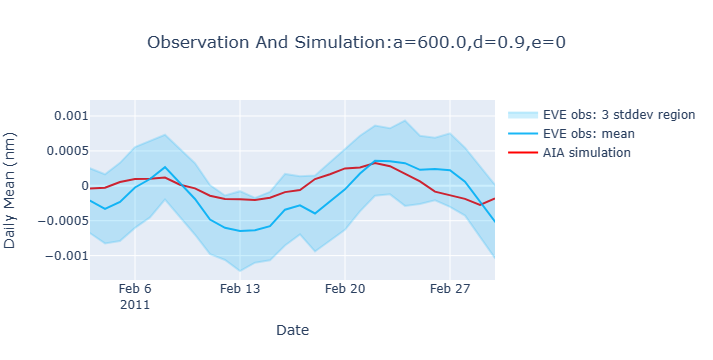

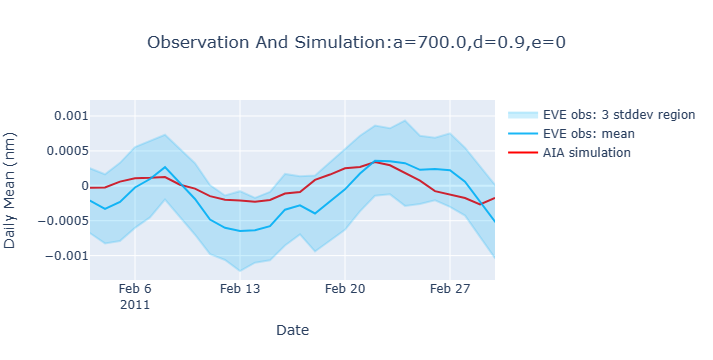

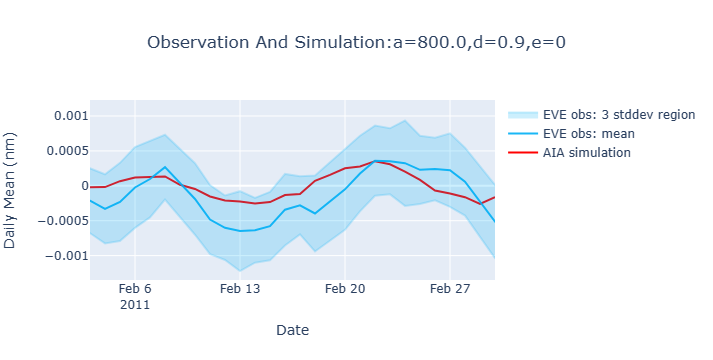

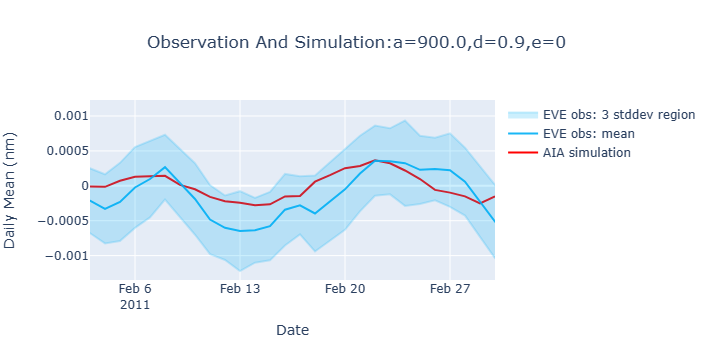

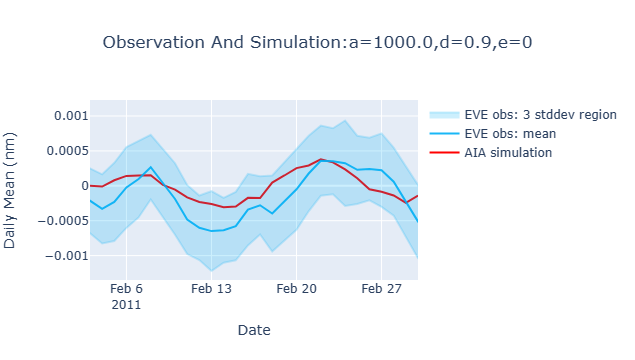

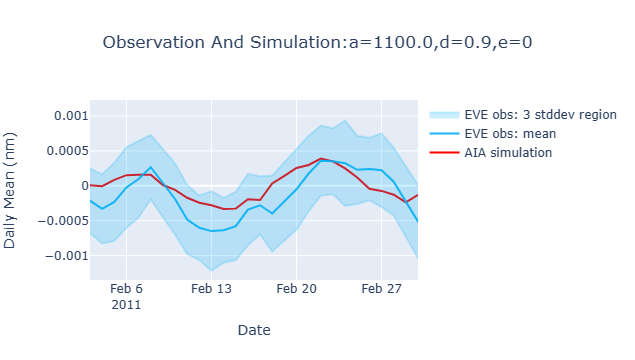

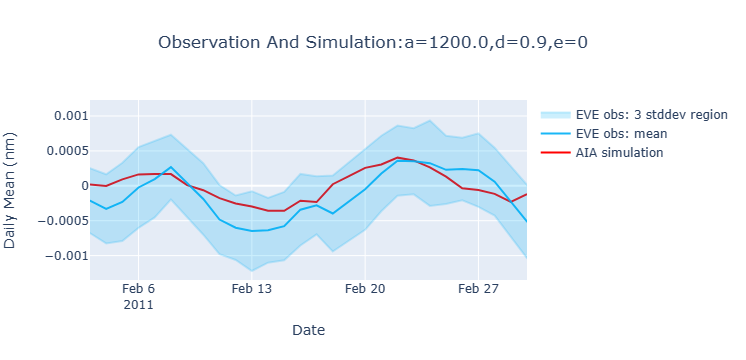

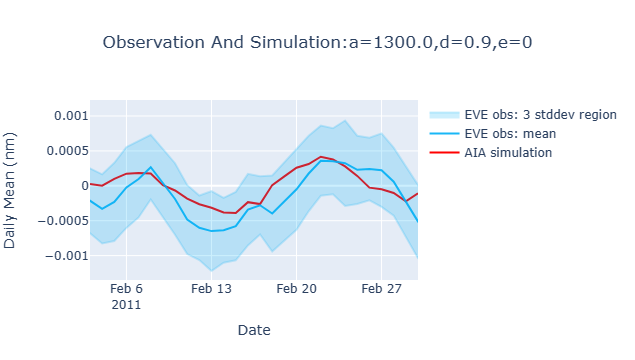

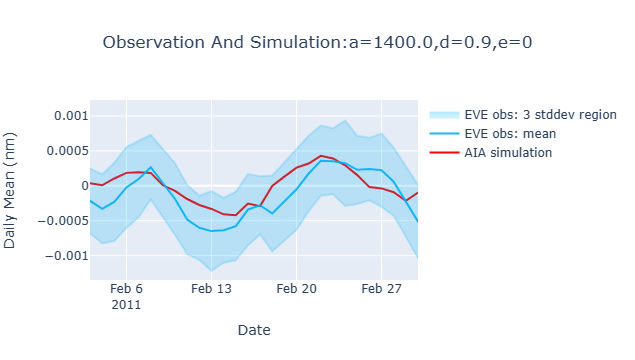

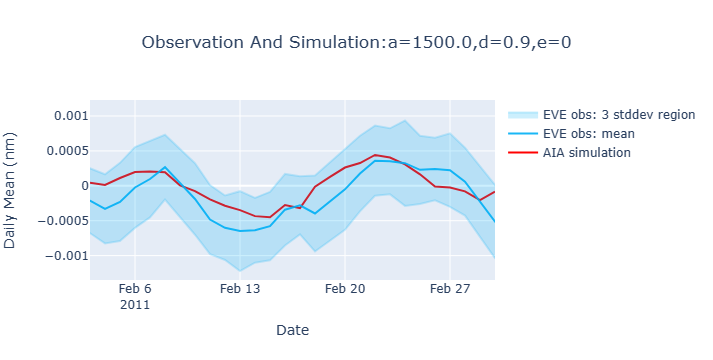

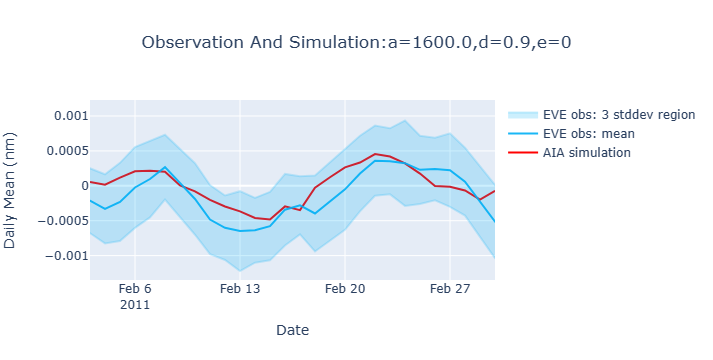

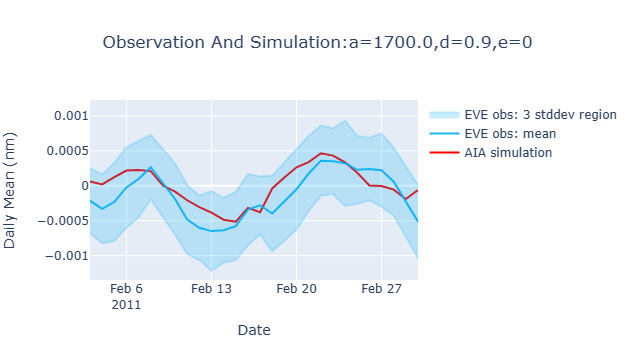

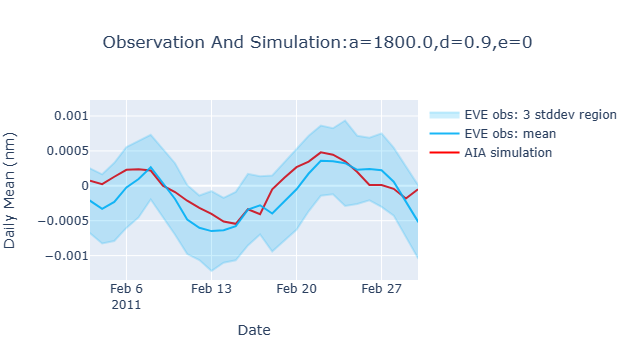

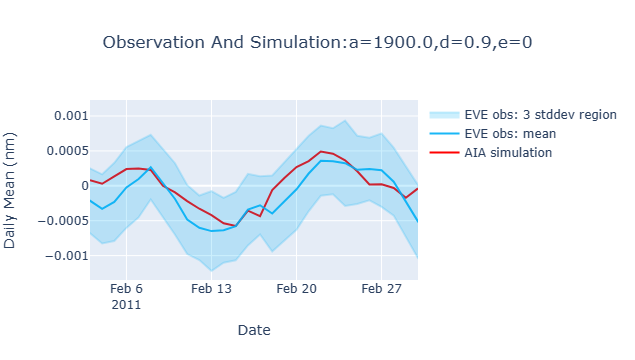

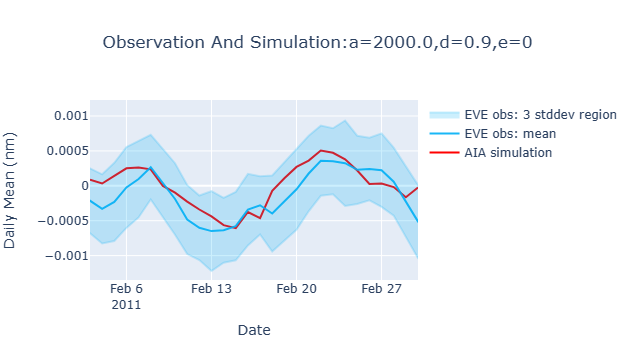

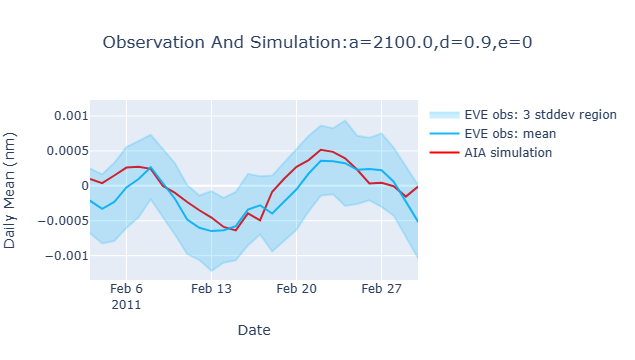

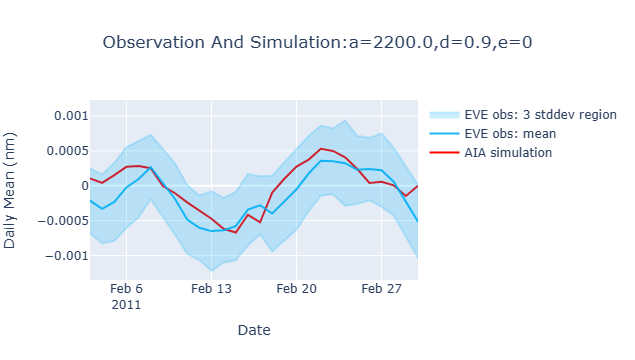

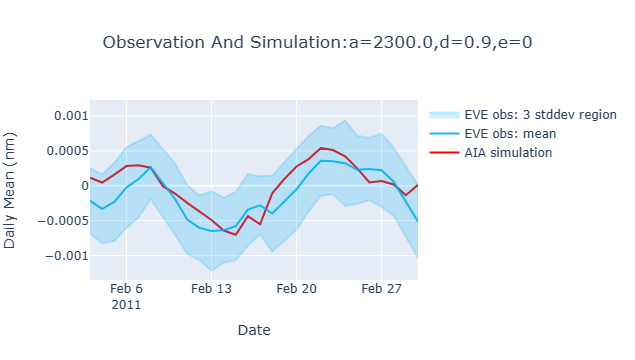

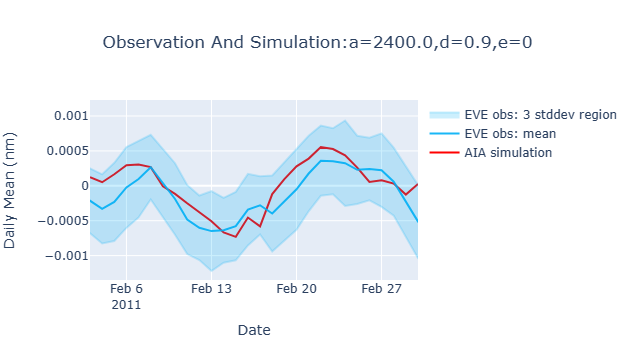

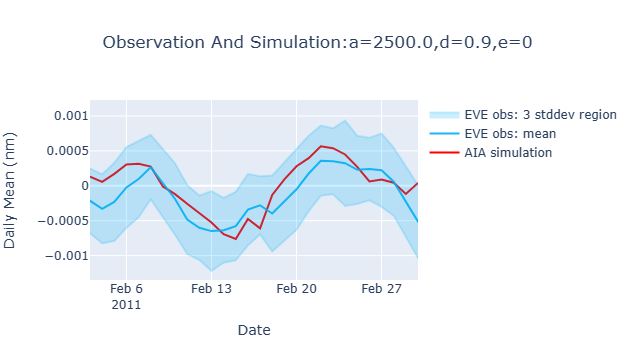

In [4]:
for a in np.linspace(600,2500,20):
    visual_3(a,.9,0)

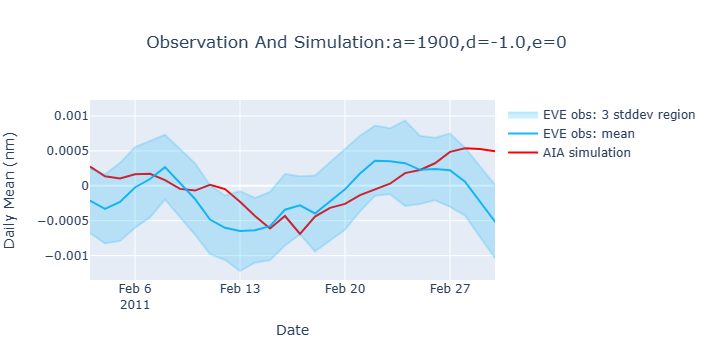

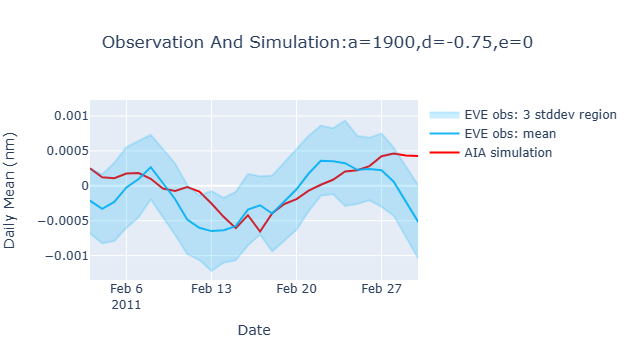

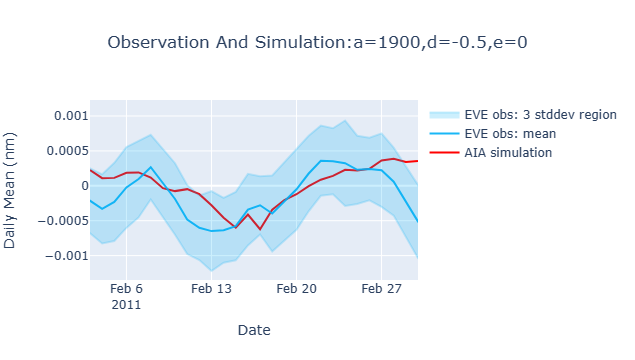

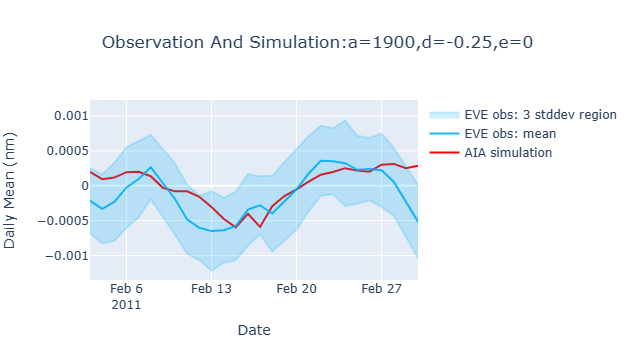

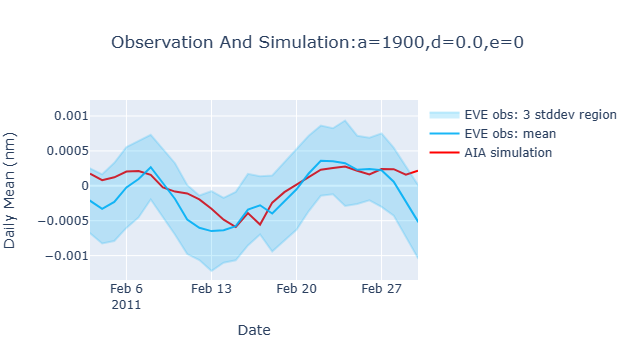

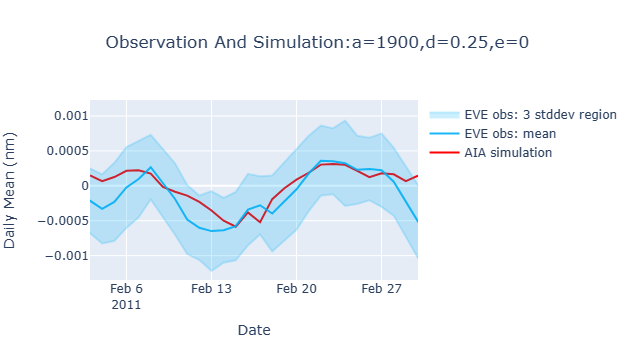

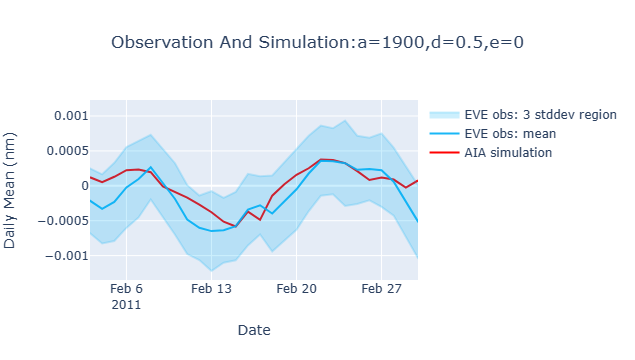

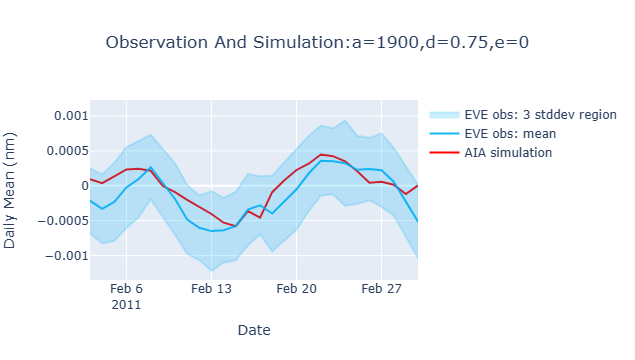

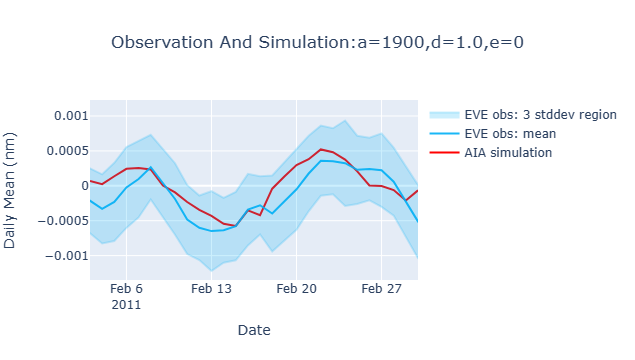

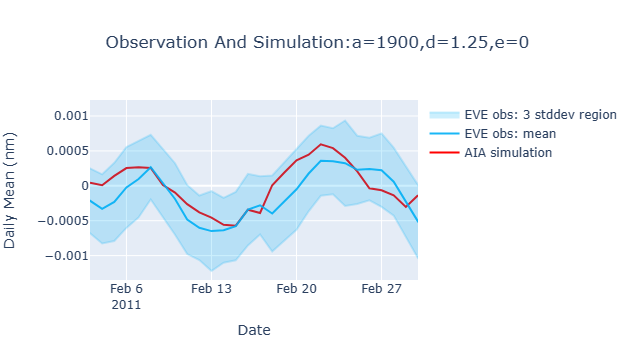

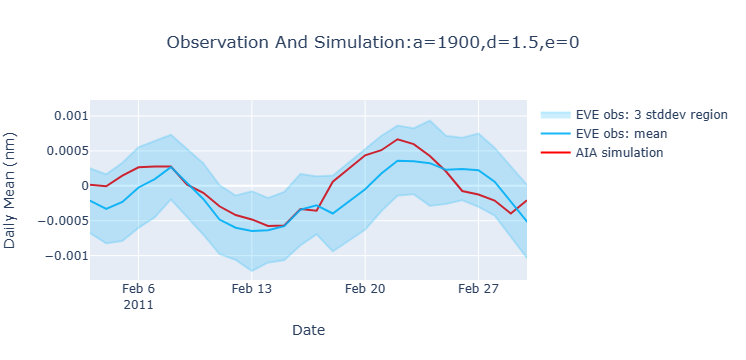

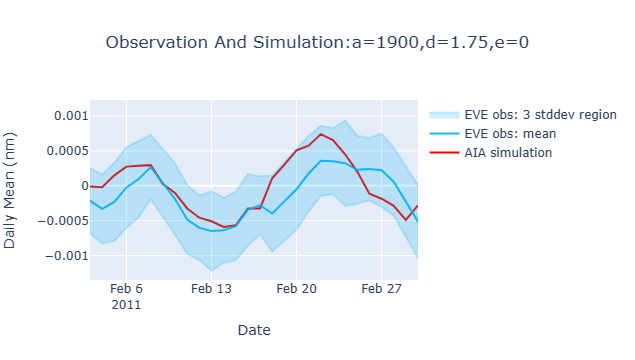

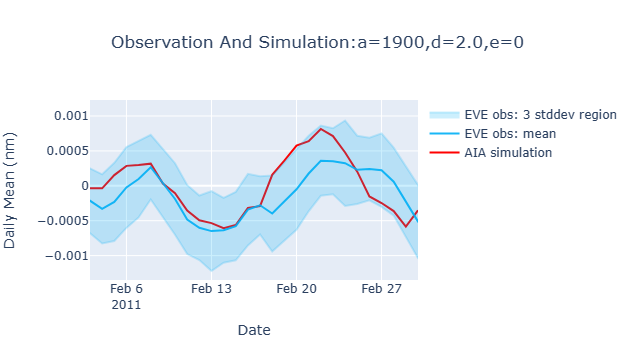

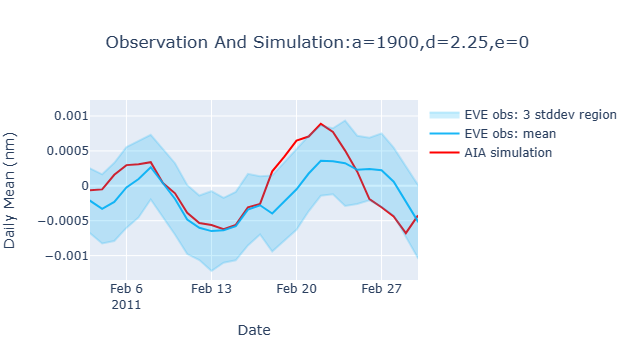

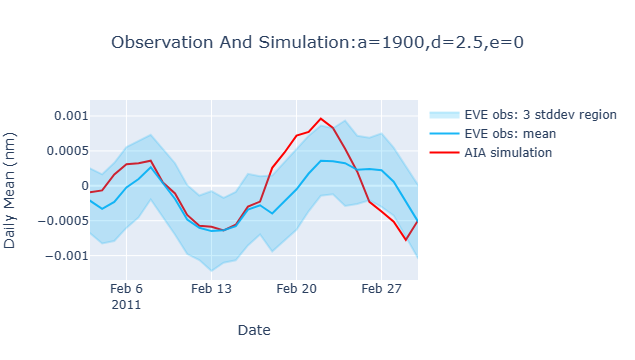

In [6]:
for b in np.linspace(-1,2.5,15):
    visual_3(1900,b,0)

In [7]:
error_function([1900,.9,0])

0.0054709521580078085

### 3-parameter optimal value

从以上几十张图可以看出大概的最佳拟合为 

a,  d = [ 1.8e3,  7.8e-1]

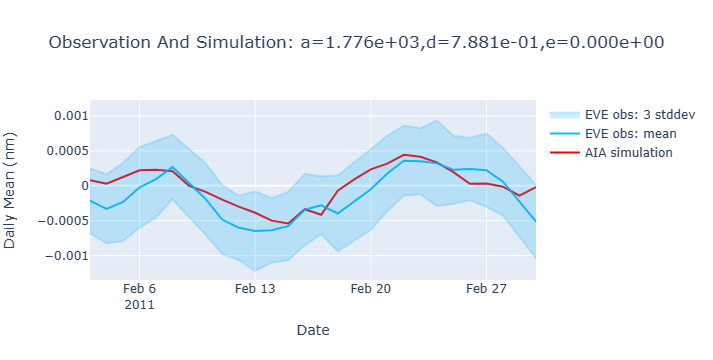

In [10]:
visual_3(1.77634512e+03 , 7.88081229e-01,0)

## 5-parameter optimization result

In [3]:
def visual_5(a,b,c,d,e):
    # 调整至原点
    temp=get_aia_simu_5(a, b,c, d, e)
    aia_simu_data={
                   'date':list(temp.keys()),
                   'daily_mean':list(temp.values()),
                    }
    aia_frame=pd.DataFrame(aia_simu_data)
    aia_frame=aia_frame.set_index('date')
    
    fig = go.Figure()
    # Plot the mean line
    fig.add_trace(go.Scatter(x=aia_frame.index, 
                             y=aia_frame['daily_mean']-np.mean(aia_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='red'),
                             name='AIA simulation'))
    
    # Plot the eve obs
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.9)'),
                             name='EVE obs: mean '))
    
    # # Plot the shaded area between the mean and 3 standard deviations
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] + 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             showlegend=False))
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] - 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             fill='tonexty', 
                             fillcolor='rgba(0,176,246,0.2)', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             name='EVE obs: 3 stddev'))
    # fill 指令，画出与上一个scatter line 之间的区域

    # Add axis labels and titles
    fig.update_layout(xaxis_title='Date', 
                      yaxis_title='Daily Mean (nm)', 
                      title={
                            'text': f'a={a:.2e},b={b:.2e},c={c:.2e},d={d:.2e},e={e:.2e}',
                            
                            'x': 0.5,
                            'y': 0.9,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                      xaxis_range=[aia_frame.index[0], aia_frame.index[-1]],
                      # legend={'yanchor': 'bottom'},
                     )
                    
    fig.show()

In [74]:
error_function_5([1.10278889e+03, -1.09299415e+00 , 4.40749161e+02 , 6.26242867e-01,
 -1.31379804e-02])

3.718033429169309e-07

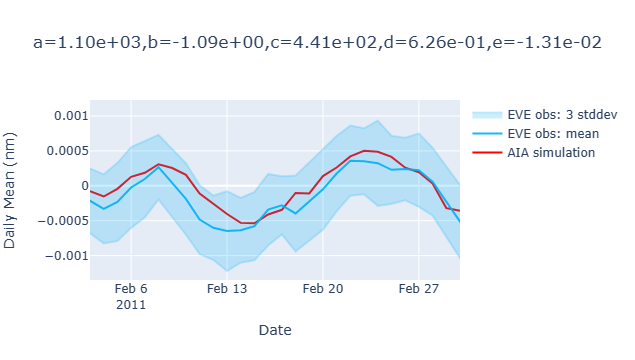

In [14]:
#不同值作为初始值得到的最优解不一样
#不同解之间看起来没太大差异
visual_5(1.10278889e+03, -1.09299415e+00 , 4.40749161e+02 , 6.26242867e-01,
 -1.31379804e-02)

In [5]:
visual_5(1.10278889e+03, 1 , 4.40749161e+02 , 6.26242867e-01,
 -1.31379804e-02)

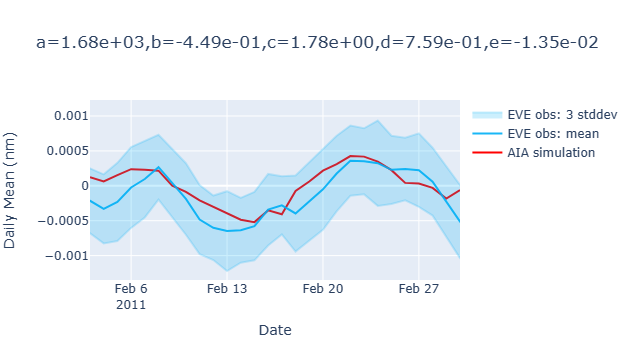

In [13]:
visual_5(1.685e+03,-4.490e-01,  1.779e+00 , 7.592e-01 ,-1.355e-02)

## Analysis/Explaination of the coeff
$$
\Delta \lambda=a  T_x^2 + b  T_x+cT_y^2+d T_y+e
$$

In [11]:
angular_radius=sunpy.sun.constants.get('average angular size')
angular_radius=angular_radius.to(u.rad)
#角度遍布整个日面
Tx=np.linspace(-angular_radius,angular_radius,200)
Ty=np.linspace(-angular_radius,angular_radius,200)

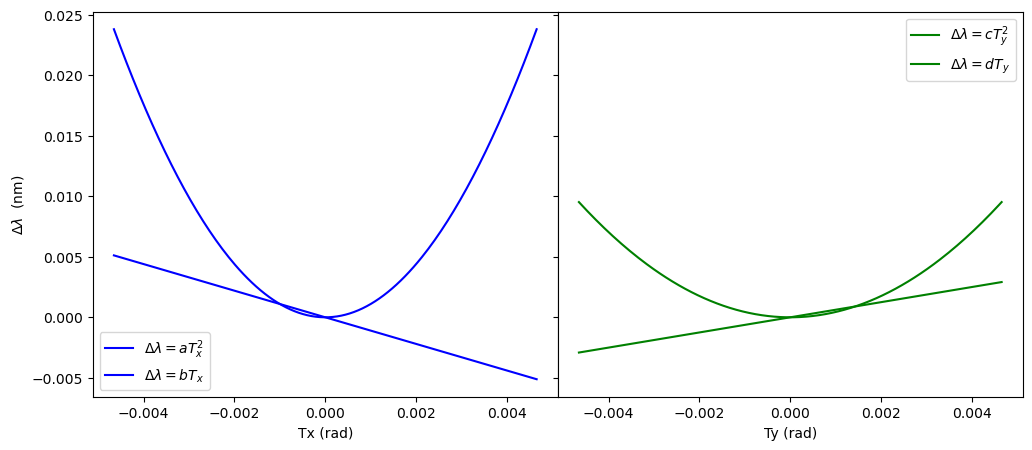

In [12]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
axs[0].plot(Tx,1.1e3*Tx**2,label=r'$\Delta \lambda=a  T_x^2$',c='b')
axs[0].plot(Tx,-1.1*Tx,label=r'$\Delta \lambda=b  T_x$',c='b')
axs[1].plot(Ty,4.4e2*Ty**2,label=r'$\Delta \lambda=cT_y^2$',c='g')
axs[1].plot(Ty,6.26e-1*Ty,label=r'$\Delta \lambda=d T_y$',c='g')

y_min, y_max = axs[0].get_ylim()
axs[1].set_ylim(y_min, y_max)



axs[0].set_ylabel(r'$\Delta \lambda$  (nm)')
axs[0].set_xlabel('Tx (rad)')
axs[1].set_xlabel('Ty (rad)')

axs[1].set_yticklabels([])
axs[1].set_ylabel('')

plt.subplots_adjust(wspace=0)


axs[0].legend()
axs[1].legend()

原理猜测
![微信图片_20230514194039](./readme.assets/微信图片_20230514194039.jpg)
![微信图片_20230514194109](./readme.assets/微信图片_20230514194109.jpg)